In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

%matplotlib inline
import sys
sys.path.insert(0, '..')
import dognet
from dognet.data import SynapseType,SynapseSignalModel

In [2]:
import torch
import torch.nn as nn

def get_normparams(data):
    return data.mean(axis=(0,2,3)),data.min(axis=(0,2,3)),data.max(axis=(0,2,3))

def normalize(im,norm_data):
    meanx,minx,maxx = norm_data
    x = np.copy(im.astype(np.float32))
    x = x.transpose(1,2,0)
    x = (x - meanx - minx)/(maxx - minx)
    return x.transpose(2,0,1)

def inference(net,image,get_intermediate=False):
    x = np.expand_dims(image,0)
    vx = torch.from_numpy(x).float().cuda()
    
    res,inter = net(vx)
    if get_intermediate:
        return res.data.cpu().numpy(),inter.data.cpu().numpy()
    return res.data.cpu().numpy()


def trial(synapse_model,net,synapses,distractors,channel_order,verbose=False,loss="bce",optimizer=None,regk=0.):
    data,labels = synapse_model.generate_for_train(synapses,distractors,channel_order)
    norm_params = get_normparams(data)
    gen = dognet.create_generator([normalize(data[0],norm_params)], [labels])
    net.weights_init()
    
    net,errors = dognet.train_routine(net,gen,n_iter=2000,margin=5,loss=loss,optimizer=optimizer,verbose=verbose,regk=regk)
    
    
    stats = 0,0,0
    for _ in range(10):
        test_data,test_labels,x,y = synapse_model.generate_for_train(synapses,distractors,channel_order,returnxy=True)   
        y_pred = inference(net,normalize(test_data[0],norm_params))

        xx,yy,_ = dognet.find_peaks(y_pred[0,0],distance=3)
        gt_pts = np.array([x,y]).transpose(1,0)
        dog_pts = np.array([xx,yy]).transpose(1,0)

        if(dog_pts.shape[0] is not 0):
            prec,rec,f1,coords = dognet.get_metric(gt_pts,dog_pts,s=3.)
            stats += prec,rec,f1
   
    stats = np.array(stats).reshape(-1,3)
    return stats.mean(0),errors

In [3]:
size=(256,256)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#nets = [DeepIsotropic(3,15,4).to(device)]#[Baseline7(3).to(device)]
baselines = [dognet.baselines.Direct(3,3),
       dognet.baselines.FCN(3,3),      
       dognet.baselines.U_net(3,2)]

# deepdogs = [
#             dognet.SimpleIsotropic(3,15,3),
#        dognet.SimpleAnisotropic(3,15,3),
#        dognet.DeepAnisotropic(3,15,3,2),
#        dognet.DeepIsotropic(3,15,3,2)]
deepdogs = [
            dognet.SimpleIsotropic(3,15,2),
       dognet.DeepIsotropic(3,15,3,2)]
#,dognet.DeepAnisotropic(3,15,3,2)] 
names = ['$Neiland2014$','$Simhal2017$','$Direct$','$FCN_3$','$U-Net_1$','$Shallow_2^4$','$Deep^4_{3,2}$']  
nets = baselines+deepdogs
nets = [net.to(device) for net in nets]
#nets =[dognet.SimpleIsotropic(3,15,4).to(device),dognet.DeepIsotropic(3,15,4).to(device),dognet.baselines.Direct(3,3).to(device), dognet.baselines.FCN(3).to(device), dognet.baselines.U_net(3).to(device)]

disps =  [0.,1.,2.]
gains = [0.0,0.01,0.02,0.03,0.04,0.05]
#disps =  [0.,1.]
#gains = [0.0,0.01,0.02]

def study(disps,gains,nets,name='res',rep=0):
    res = np.zeros((len(gains),len(nets)+2,len(disps)))
    for dind,disp in enumerate(disps):
        synapse1 = SynapseType(["synapsin","psd"],disp,intensity=[1.,1.],psf=[1.,1.],marker_size=2.)
        synapse2 = SynapseType(["vglut","psd"],disp,intensity=[1.,1.],psf=[1.,1.],marker_size=2.)
        dst1= SynapseType(["psd"],0.,intensity=[1.],psf=[1.])
        dst2 = SynapseType(["vglut"],0.,intensity=[1.],psf=[1.])
        dst3 = SynapseType(["synapsin"],0.,intensity=[1.],psf=[1.])

        print('disp',dind)

        for ind, gain in enumerate(gains):
            sm = SynapseSignalModel([synapse1,synapse2],[dst1,dst2,dst3],size,gain=10.,default_noise_gain=gain)
            x,y,xxg,yyg = sm.generate_for_train([25,20],[10,10,10],order=["synapsin","psd","vglut"],returnxy=True)

            print('gain',gain)
            r = dognet.cellprofiler_pipeline([x[0,0]],[x[0,1]],15)
            fpr, tpr, thresholds = roc_curve( y.flatten(),r.flatten())
            res[ind,0,dind] = auc(fpr, tpr)
            #print('Neiland',roc_auc)

            prob = 1.-dognet.baselines.probabilistic_synapse_segmentation(x[0,0:1],x[0,1:2],max_size=11,window_size=2)
            fpr, tpr, thresholds = roc_curve( y.flatten(),prob[0].flatten())
            res[ind,1,dind] = auc(fpr, tpr)
            #print('Prob',roc_auc)

            for nind,net in enumerate(nets):
                optim = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)
                data,err = trial(sm,net,[25,10],[10,10,10],["synapsin","psd","vglut"],regk=0.01,optimizer=optim,loss="softdice")

                norm_params = get_normparams(x)
                z = inference(net,normalize(x[0],norm_params))
                fpr, tpr, thresholds = roc_curve( y.flatten(),z[0,0].flatten())
                res[ind,nind+2,dind] = auc(fpr, tpr)
    np.save(name+'{}'.format(rep),res)
    return res


#print(torch.norm(net.conv1.s.grad).item(),torch.norm(net.conv2.weight.grad).item())
#print data
#plt.plot(err)
#print(sm.signal_noise())

In [28]:
gains_res = [study([1.],gains,nets,name='gains',rep=i) for i in range(3)]
#gains_res = [np.load('gains{}.npy'.format(i))  for i in range(3)]
avg_gain = np.concatenate([np.expand_dims(res,0) for res in gains_res]).mean(0)[:,:,0]
stds_gain = np.concatenate([np.expand_dims(res,0) for res in gains_res]).std(0)[:,:,0]

('disp', 0)
('gain', 0.0)


/home/vkulikov/.local/lib/python2.7/site-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


('gain', 0.01)
('gain', 0.02)
('gain', 0.03)


../dognet/training.py:166: RuntimeWarning: divide by zero encountered in double_scalars
  ky = torch.FloatTensor([(y.shape[-1]*y.shape[-2]-y.sum()/y.shape[0])/y[0,0].sum()*y.shape[0]]).to(device)


('gain', 0.04)
('gain', 0.05)


../dognet/utils.py:90: RuntimeWarning: invalid value encountered in divide
  norm = (probimage - probimage.min()) / (probimage.max() - probimage.min()) * 255.


('disp', 0)
('gain', 0.0)
('gain', 0.01)
('gain', 0.02)
('gain', 0.03)
('gain', 0.04)
('gain', 0.05)
('disp', 0)
('gain', 0.0)
('gain', 0.01)
('gain', 0.02)
('gain', 0.03)
('gain', 0.04)
('gain', 0.05)


In [40]:
#names = ['$Neiland2014$','$Simhal2017$','$Shallow_4^2$','$Deep^4_{3,2}$','$Direct$','$FCN$','$U-Net$']
names = ['$Neiland2014$','$Simhal2017$','$Direct$','$FCN$','$U-Net$','$Shallow_4^2$','$Deep^4_{3,2}$']

def draw(means,stds,names,tics,namex,xlabel="Signal-to-noise ratio"):
    error_config = {'ecolor': '0.3'}
    bar_width = 0.13
    opacity = 0.8
    disp = 0

    rects = []
    fig, ax = plt.subplots(figsize=(10,5))
    index = np.arange(means.shape[0])
    plt.ylim((0.5,1.05))
    for i,name in enumerate(names):
        rects +=  [ax.bar(index+ bar_width*i-bar_width*(means.shape[0]-1)*0.5, means[:,i], bar_width, alpha=opacity,  yerr=stds[:,i], error_kw=error_config, label=name)]
    plt.legend(handles=rects,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(range(means.shape[0]), tics)
    plt.xlabel(xlabel)
    plt.ylabel("AUC")
    plt.savefig(namex+'.tiff', bbox_inches='tight', dpi=300)
    plt.show()

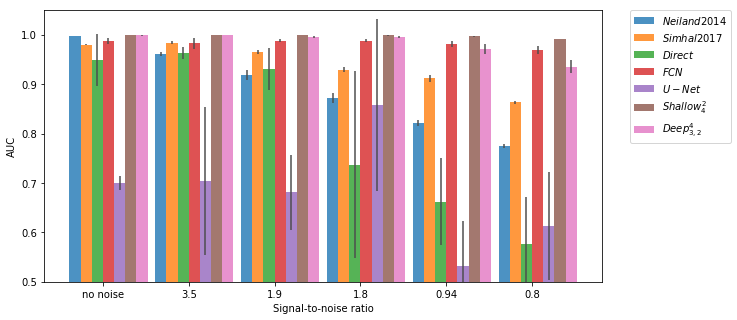

In [41]:
snr=[]
disp =0.
synapse1 = SynapseType(["synapsin","psd"],disp,intensity=[1.,1.],psf=[1.,1.],marker_size=2.)
synapse2 = SynapseType(["vglut","psd"],disp,intensity=[1.,1.],psf=[1.,1.],marker_size=2.)
dst1= SynapseType(["psd"],0.,intensity=[1.],psf=[1.])
dst2 = SynapseType(["vglut"],0.,intensity=[1.],psf=[1.])
dst3 = SynapseType(["synapsin"],0.,intensity=[1.],psf=[1.])
for ind, gain in enumerate(gains):
    sm = SynapseSignalModel([synapse1,synapse2],[dst1,dst2,dst3],size,gain=10.,default_noise_gain=gain)
    snr+=["{:.2}".format(np.array(sm.signal_noise()).mean())]
snr[0]='no noise'
draw(avg_gain,stds_gain,names,snr,'Fig_4')

In [33]:
shifts_res = [study([0.,1.,2.,3.,4.],[0.02],nets,name='shifts',rep=i) for i in range(3)]
avg_shifts = np.concatenate([np.expand_dims(res,0) for res in shifts_res]).mean(0)[0,:,:].transpose(1,0)
stds_shifts = np.concatenate([np.expand_dims(res,0) for res in shifts_res]).std(0)[0,:,:].transpose(1,0)

('disp', 0)
('gain', 0.02)
('disp', 1)
('gain', 0.02)
('disp', 2)
('gain', 0.02)
('disp', 3)
('gain', 0.02)
('disp', 4)
('gain', 0.02)
('disp', 0)
('gain', 0.02)
('disp', 1)
('gain', 0.02)
('disp', 2)
('gain', 0.02)
('disp', 3)
('gain', 0.02)
('disp', 4)
('gain', 0.02)
('disp', 0)
('gain', 0.02)
('disp', 1)
('gain', 0.02)
('disp', 2)
('gain', 0.02)
('disp', 3)
('gain', 0.02)
('disp', 4)
('gain', 0.02)


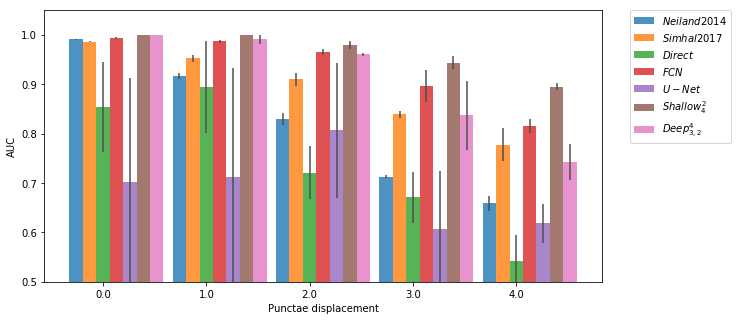

In [42]:
draw(avg_shifts,stds_shifts,names,[0.,1.,2.,3.,4.],"Fig_5","Punctae displacement")

(1.6757878e-07, 0.99658453)


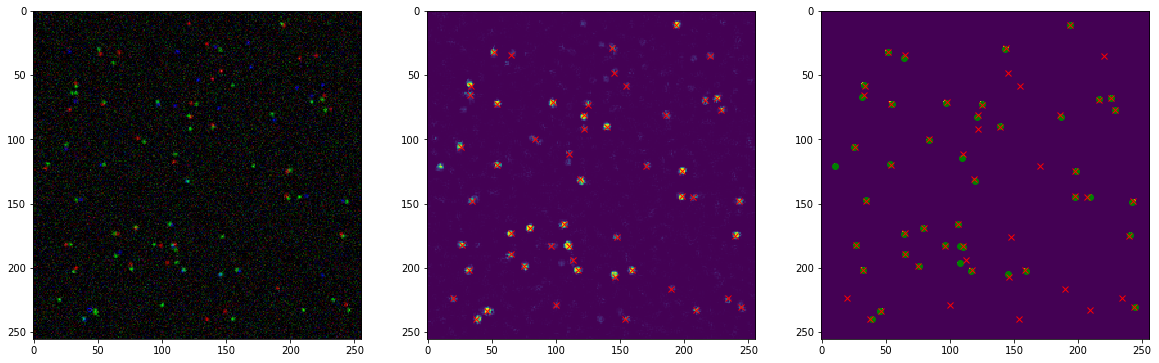

In [56]:
x,y,xxg,yyg = sm.generate_for_train([25,20],[10,10,10],order=["synapsin","psd","vglut"],returnxy=True)
norm_params = get_normparams(x)
z = inference(net,normalize(x[0],norm_params))
#z = z[0,0].detach().cpu().numpy()
z = z[0,0]
xx,yy,_ = dognet.find_peaks(z,distance=4,minval=0.2)

f,ax = plt.subplots(1,3,figsize=(20,20))
ax[0].imshow(x[0].transpose(1,2,0)*5)
print(z.min(),z.max())
ax[1].imshow(z)

ax[1].plot(yy,xx,'rx')
ax[2].imshow(y)

ax[2].plot(yyg,xxg,'go')
ax[2].plot(yy,xx,'rx')